In [ ]:
!pip install kaggle



In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

!unzip brain-tumor-mri-dataset.zip -d dataset


Streaming output truncated to the last 5000 lines.
  inflating: dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0726.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0727.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0728.jpg  
  inflating: dataset/Training/g

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# import system libs
import os
import itertools
from PIL import Image

# import data handling tools
import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [ ]:
# Generate data paths with labels
train_data_dir = 'dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# print(labels)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

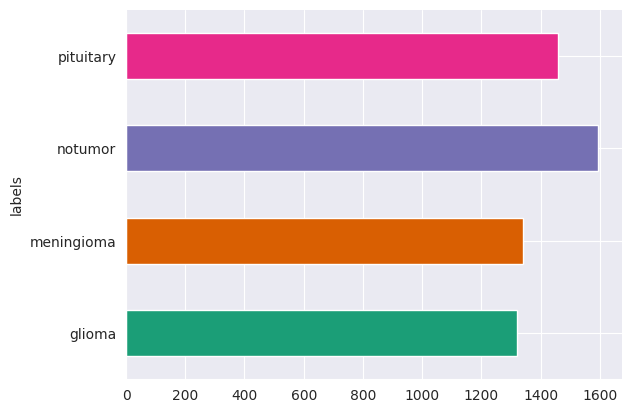

In [ ]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Generate data paths with labels
test_data_dir = 'dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

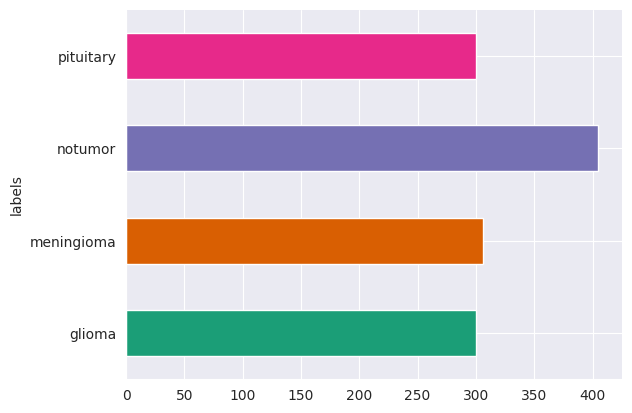

In [ ]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
ts_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=51c0c345a35ba15816792ddffd2167797abfda3cddfc0867b417643e88bea9f5
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


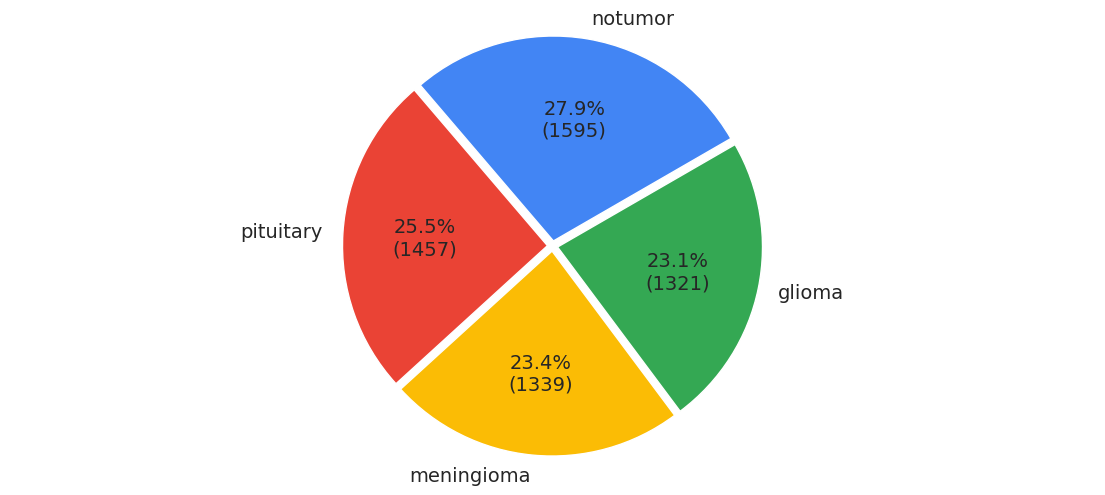

In [ ]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()

In [ ]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
#Augment and Preprocess Scans
batch_size = 32
img_size = (240, 240)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
#For data manipulation
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance
import psutil
import GPUtil


#For neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

# ***---------VGG16---------***

In [ ]:
# Create VGG16 model architecture
img_size = 240
class_count = len(list(train_gen.class_indices.keys()))

base_model = VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

vgg_model = Sequential()

vgg_model.add(Input(shape=(img_size, img_size, 3)))
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(class_count, activation='softmax'))

vgg_model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

In [ ]:
vgg_model.compile(optimizer = Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# Start time
start_time = time.time()

# Train the model
history_vgg =vgg_model.fit(
    train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)

# End time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print training time
print(f"Training Time: {training_time} seconds")

# CPU utilization
cpu_utilization = psutil.cpu_percent()
print(f"CPU Utilization: {cpu_utilization}%")

# GPU utilization
gpus = GPUtil.getGPUs()
gpu_utilization = [gpu.load for gpu in gpus]
print(f"GPU Utilization: {gpu_utilization}")


Epoch 1/20
179/179 [==============================] - 43s 241ms/step - loss: 0.8215 - accuracy: 0.7414 - val_loss: 0.4985 - val_accuracy: 0.7939
Epoch 2/20
179/179 [==============================] - 33s 181ms/step - loss: 0.3275 - accuracy: 0.8834 - val_loss: 0.3060 - val_accuracy: 0.8733
Epoch 3/20
179/179 [==============================] - 37s 207ms/step - loss: 0.2215 - accuracy: 0.9212 - val_loss: 0.2219 - val_accuracy: 0.9038
Epoch 4/20
179/179 [==============================] - 34s 189ms/step - loss: 0.1592 - accuracy: 0.9442 - val_loss: 0.1741 - val_accuracy: 0.9344
Epoch 5/20
179/179 [==============================] - 36s 202ms/step - loss: 0.1439 - accuracy: 0.9489 - val_loss: 0.1633 - val_accuracy: 0.9405
Epoch 6/20
179/179 [==============================] - 38s 212ms/step - loss: 0.1051 - accuracy: 0.9625 - val_loss: 0.2301 - val_accuracy: 0.9374
Epoch 7/20
179/179 [==============================] - 34s 189ms/step - loss: 0.0878 - accuracy: 0.9697 - val_loss: 0.1074 - val_ac

NameError: name 'psutil' is not defined

In [ ]:
# CPU utilization
cpu_utilization = psutil.cpu_percent()
print(f"CPU Utilization: {cpu_utilization}%")

# GPU utilization
gpus = GPUtil.getGPUs()
gpu_utilization = [gpu.load for gpu in gpus]
print(f"GPU Utilization: {gpu_utilization}")


CPU Utilization: 35.4%
GPU Utilization: [0.0]


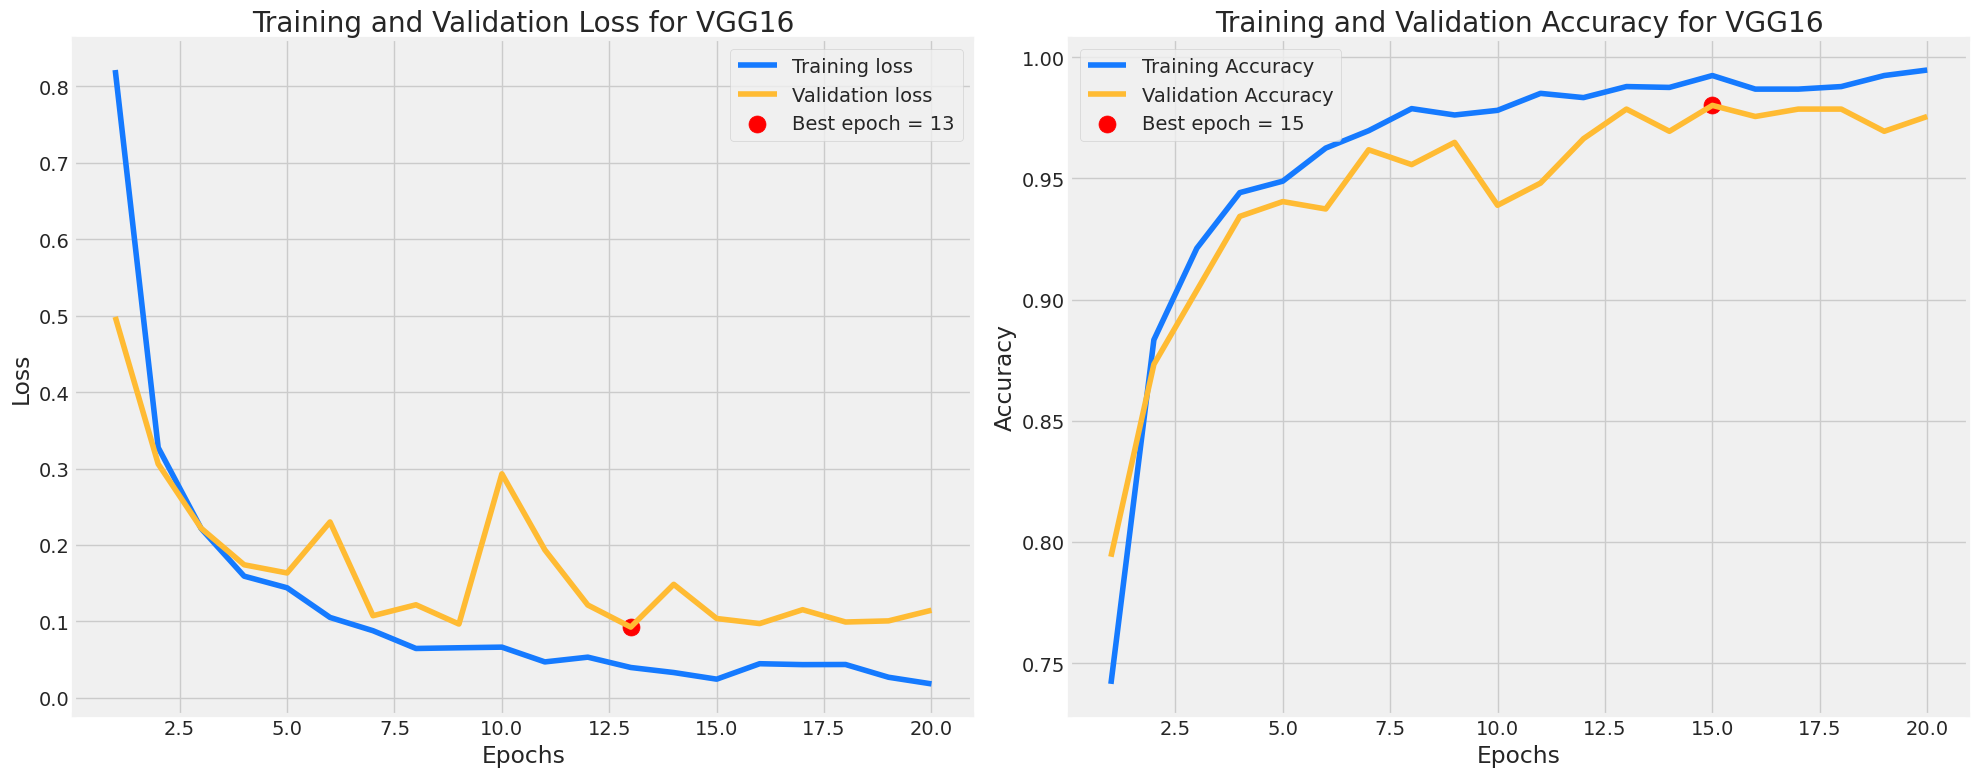

In [ ]:
# Graph results for VGG16 model
tr_acc_vgg = history_vgg.history['accuracy']
tr_loss_vgg = history_vgg.history['loss']
val_acc_vgg = history_vgg.history['val_accuracy']
val_loss_vgg = history_vgg.history['val_loss']
index_loss_vgg = np.argmin(val_loss_vgg)
val_lowest_vgg = val_loss_vgg[index_loss_vgg]
index_acc_vgg = np.argmax(val_acc_vgg)
acc_highest_vgg = val_acc_vgg[index_acc_vgg]

Epochs_vgg = [i + 1 for i in range(len(tr_acc_vgg))]
loss_label_vgg = f'Best epoch = {str(index_loss_vgg + 1)}'
acc_label_vgg = f'Best epoch = {str(index_acc_vgg + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_vgg, tr_loss_vgg, color='#157AFF', label='Training loss')
plt.plot(Epochs_vgg, val_loss_vgg, color='#FFBB33', label='Validation loss')
plt.scatter(index_loss_vgg + 1, val_lowest_vgg, s=150, color='red', label=loss_label_vgg)
plt.title('Training and Validation Loss for VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_vgg, tr_acc_vgg, color='#157AFF', label='Training Accuracy')
plt.plot(Epochs_vgg, val_acc_vgg, color='#FFBB33', label='Validation Accuracy')
plt.scatter(index_acc_vgg + 1, acc_highest_vgg, s=150, color='red', label=acc_label_vgg)
plt.title('Training and Validation Accuracy for VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Results for training, validating, testing for VGG16 model
train_score_vgg = vgg_model.evaluate(train_gen, verbose=1)
valid_score_vgg = vgg_model.evaluate(valid_gen, verbose=1)
test_score_vgg = vgg_model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score_vgg[0])
print("Train Accuracy: ", train_score_vgg[1])
print('-' * 20)
print("Validation Loss: ", valid_score_vgg[0])
print("Validation Accuracy: ", valid_score_vgg[1])
print('-' * 20)
print("Test Loss: ", test_score_vgg[0])
print("Test Accuracy: ", test_score_vgg[1])


21/21 [==============================] - 3s 139ms/step - loss: 0.0586 - accuracy: 0.9848
Train Loss:  0.0035767010413110256
Train Accuracy:  0.9991246461868286
--------------------
Validation Loss:  0.11457560211420059
Validation Accuracy:  0.9755725264549255
--------------------
Test Loss:  0.05863715335726738
Test Accuracy:  0.9847561120986938


21/21 [==============================] - 3s 142ms/step


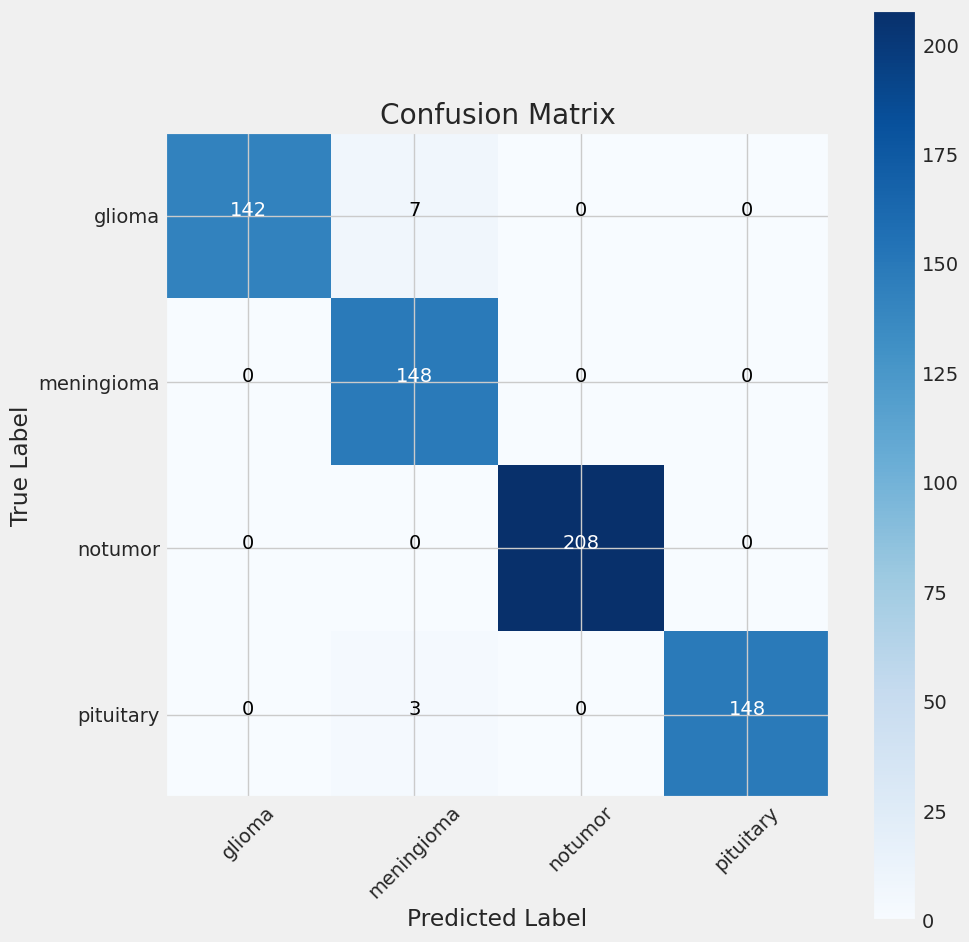

In [ ]:
# Predictions
preds_vgg = vgg_model.predict(test_gen)
y_pred_vgg = np.argmax(preds_vgg, axis=1)

# Confusion matrix
g_dict_vgg = test_gen.class_indices
classes_vgg = list(g_dict_vgg.keys())

cm_vgg = confusion_matrix(test_gen.classes, y_pred_vgg)

plt.figure(figsize=(10, 10))
plt.imshow(cm_vgg, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes_vgg))
plt.xticks(tick_marks, classes_vgg, rotation=45)
plt.yticks(tick_marks, classes_vgg)

thresh_vgg = cm_vgg.max() / 2.
for i, j in itertools.product(range(cm_vgg.shape[0]), range(cm_vgg.shape[1])):
    plt.text(j, i, cm_vgg[i, j], horizontalalignment='center', color='white' if cm_vgg[i, j] > thresh_vgg else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
vgg_model.save("VGG16.h5")

# ***-------------InceptionV3-----------***

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model, pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top of the InceptionV3 base model
inception_model = Sequential([
    Input(shape=(img_size, img_size, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation='softmax')
])

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
inception_model.summary()


87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dropout_2 (Dropout)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               9437312   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

In [ ]:
# Start time
start_time = time.time()

# Train the InceptionV3 model
inception_history = inception_model.fit(
    train_gen,
    epochs=30,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)

# End time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print training time
print(f"Training Time: {training_time} seconds")

# CPU utilization
cpu_utilization = psutil.cpu_percent()
print(f"CPU Utilization: {cpu_utilization}%")

# GPU utilization
gpus = GPUtil.getGPUs()
gpu_utilization = [gpu.load for gpu in gpus]
print(f"GPU Utilization: {gpu_utilization}")


Epoch 1/30
179/179 [==============================] - 36s 149ms/step - loss: 3.0983 - accuracy: 0.5581 - val_loss: 0.7039 - val_accuracy: 0.7328
Epoch 2/30
179/179 [==============================] - 24s 133ms/step - loss: 0.6955 - accuracy: 0.6998 - val_loss: 0.6178 - val_accuracy: 0.7908
Epoch 3/30
179/179 [==============================] - 26s 147ms/step - loss: 0.5970 - accuracy: 0.7395 - val_loss: 0.5121 - val_accuracy: 0.7863
Epoch 4/30
179/179 [==============================] - 20s 114ms/step - loss: 0.5242 - accuracy: 0.7817 - val_loss: 0.4152 - val_accuracy: 0.8290
Epoch 5/30
179/179 [==============================] - 20s 111ms/step - loss: 0.4740 - accuracy: 0.7943 - val_loss: 0.3914 - val_accuracy: 0.8366
Epoch 6/30
179/179 [==============================] - 19s 106ms/step - loss: 0.4265 - accuracy: 0.8190 - val_loss: 0.3653 - val_accuracy: 0.8458
Epoch 7/30
179/179 [==============================] - 19s 108ms/step - loss: 0.4110 - accuracy: 0.8274 - val_loss: 0.3040 - val_ac

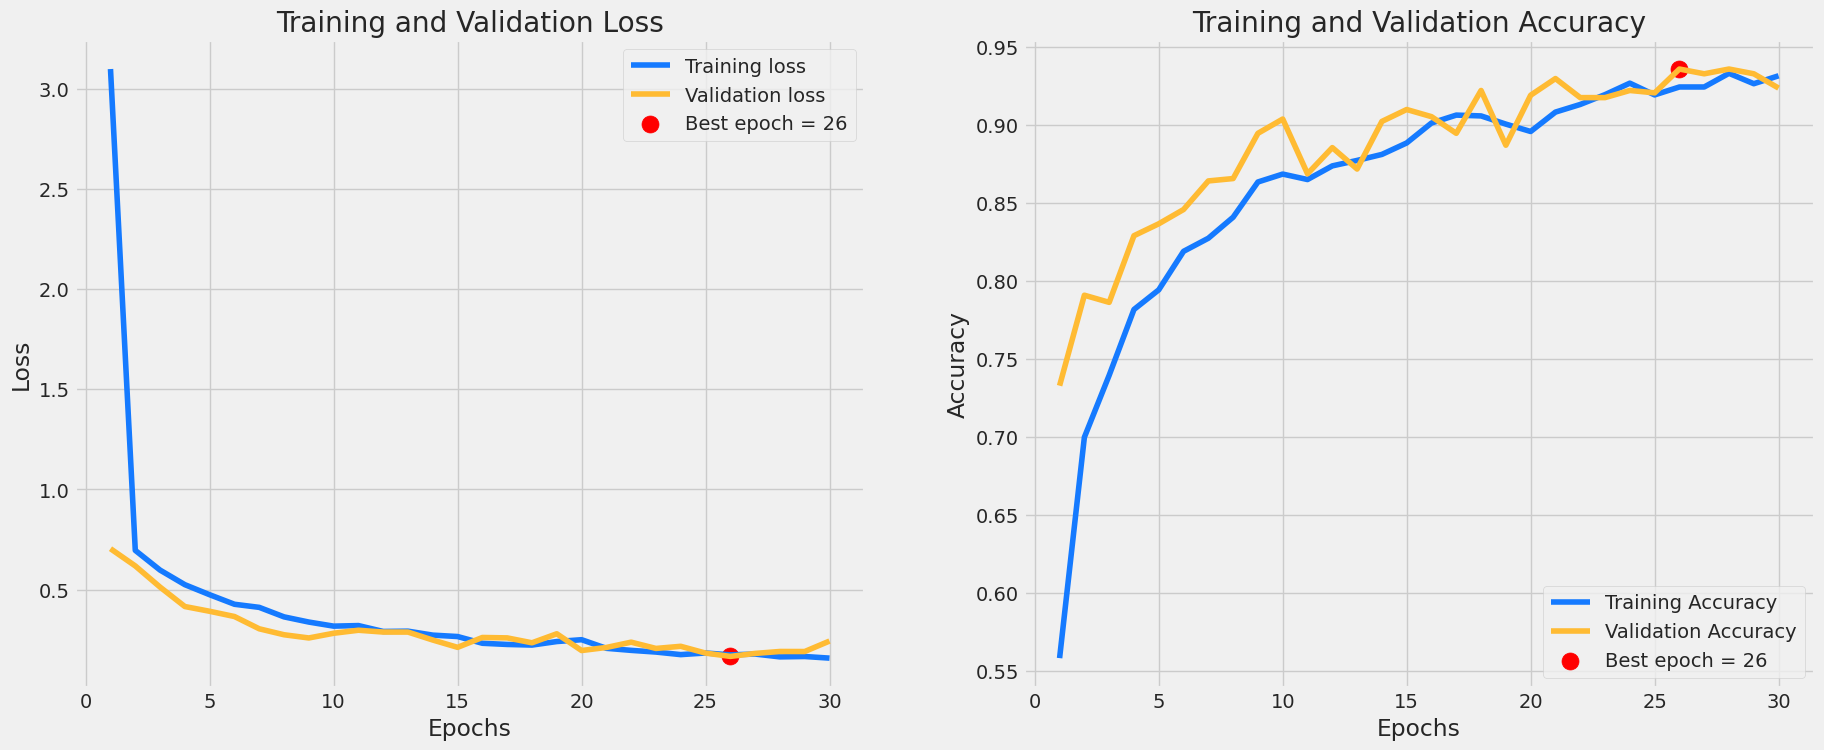

In [ ]:
# Graph results
tr_acc = inception_history.history['accuracy']
tr_loss = inception_history.history['loss']
val_acc = inception_history.history['val_accuracy']
val_loss = inception_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color='#157AFF', label='Training loss')
plt.plot(Epochs, val_loss, color='#FFBB33', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, color='red', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color='#157AFF', label='Training Accuracy')
plt.plot(Epochs, val_acc, color='#FFBB33', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, color='red', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
# Results for training, validating, testing
train_score = inception_model.evaluate(train_gen, verbose=1)
valid_score = inception_model.evaluate(valid_gen, verbose=1)
test_score = inception_model.evaluate(test_gen, verbose=1)

print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print('-' * 20)
print("Validation Loss:", valid_score[0])
print("Validation Accuracy:", valid_score[1])
print('-' * 20)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])


21/21 [==============================] - 2s 92ms/step - loss: 0.1914 - accuracy: 0.9375
Train Loss: 0.042128559201955795
Train Accuracy: 0.9877451062202454
--------------------
Validation Loss: 0.24282732605934143
Validation Accuracy: 0.9236640930175781
--------------------
Test Loss: 0.19135698676109314
Test Accuracy: 0.9375


21/21 [==============================] - 3s 105ms/step


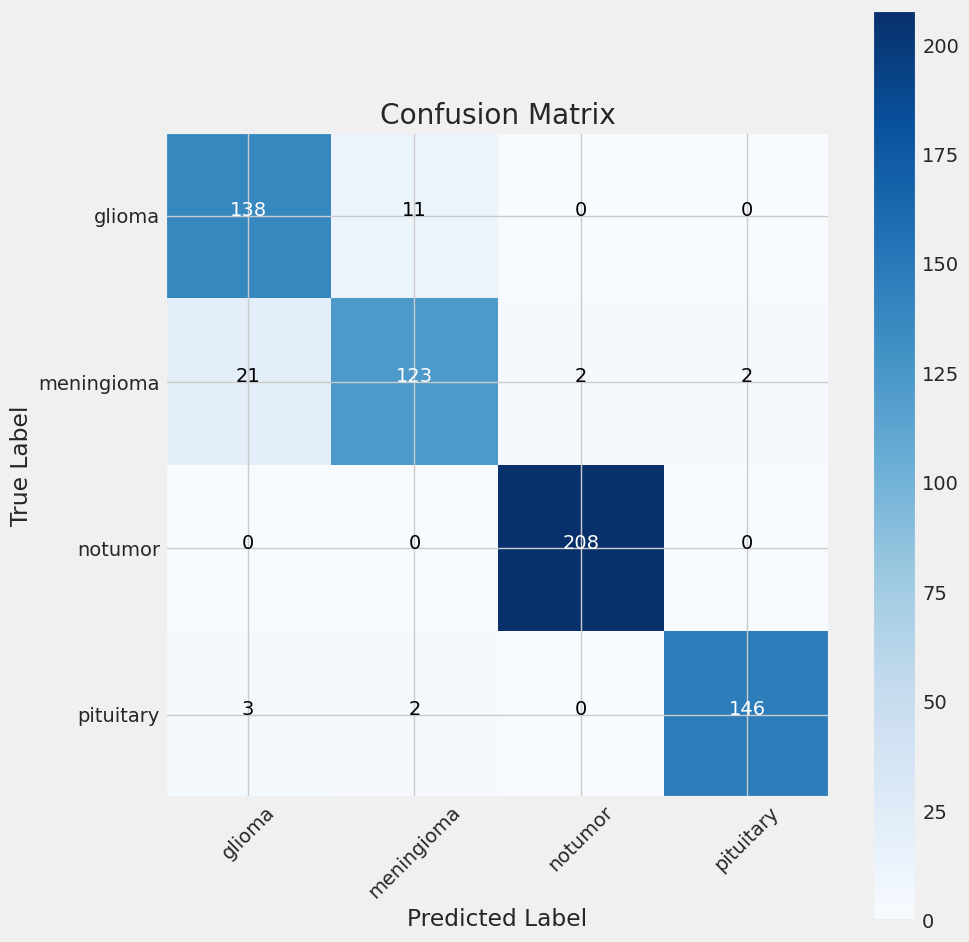

In [ ]:
preds = inception_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
inception_model.save("Inception.h5")

# ***-----------Xception-----------***

In [ ]:
from tensorflow.keras.applications import Xception

# Load the Xception model, pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top of the Xception base model
xception_model = Sequential([
    Input(shape=(img_size, img_size, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation='softmax')
])

# Compile the model
xception_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
xception_model.summary()


83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                       

In [ ]:
# Start time
start_time = time.time()

# Train the model
xception_history = xception_model.fit(
    train_gen,
    epochs=35,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)

# End time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print training time
print(f"Training Time: {training_time} seconds")

# CPU utilization
cpu_utilization = psutil.cpu_percent()
print(f"CPU Utilization: {cpu_utilization}%")

# GPU utilization
gpus = GPUtil.getGPUs()
gpu_utilization = [gpu.load for gpu in gpus]
print(f"GPU Utilization: {gpu_utilization}")


Epoch 1/35
179/179 [==============================] - 49s 230ms/step - loss: 1.4570 - accuracy: 0.6696 - val_loss: 0.6163 - val_accuracy: 0.7634
Epoch 2/35
179/179 [==============================] - 30s 169ms/step - loss: 0.5243 - accuracy: 0.7932 - val_loss: 0.4972 - val_accuracy: 0.7985
Epoch 3/35
179/179 [==============================] - 31s 172ms/step - loss: 0.4429 - accuracy: 0.8249 - val_loss: 0.4612 - val_accuracy: 0.8305
Epoch 4/35
179/179 [==============================] - 30s 168ms/step - loss: 0.3438 - accuracy: 0.8626 - val_loss: 0.3772 - val_accuracy: 0.8611
Epoch 5/35
179/179 [==============================] - 31s 171ms/step - loss: 0.3175 - accuracy: 0.8803 - val_loss: 0.3306 - val_accuracy: 0.8595
Epoch 6/35
179/179 [==============================] - 31s 171ms/step - loss: 0.2863 - accuracy: 0.8902 - val_loss: 0.2890 - val_accuracy: 0.8824
Epoch 7/35
179/179 [==============================] - 30s 167ms/step - loss: 0.2273 - accuracy: 0.9105 - val_loss: 0.2647 - val_ac

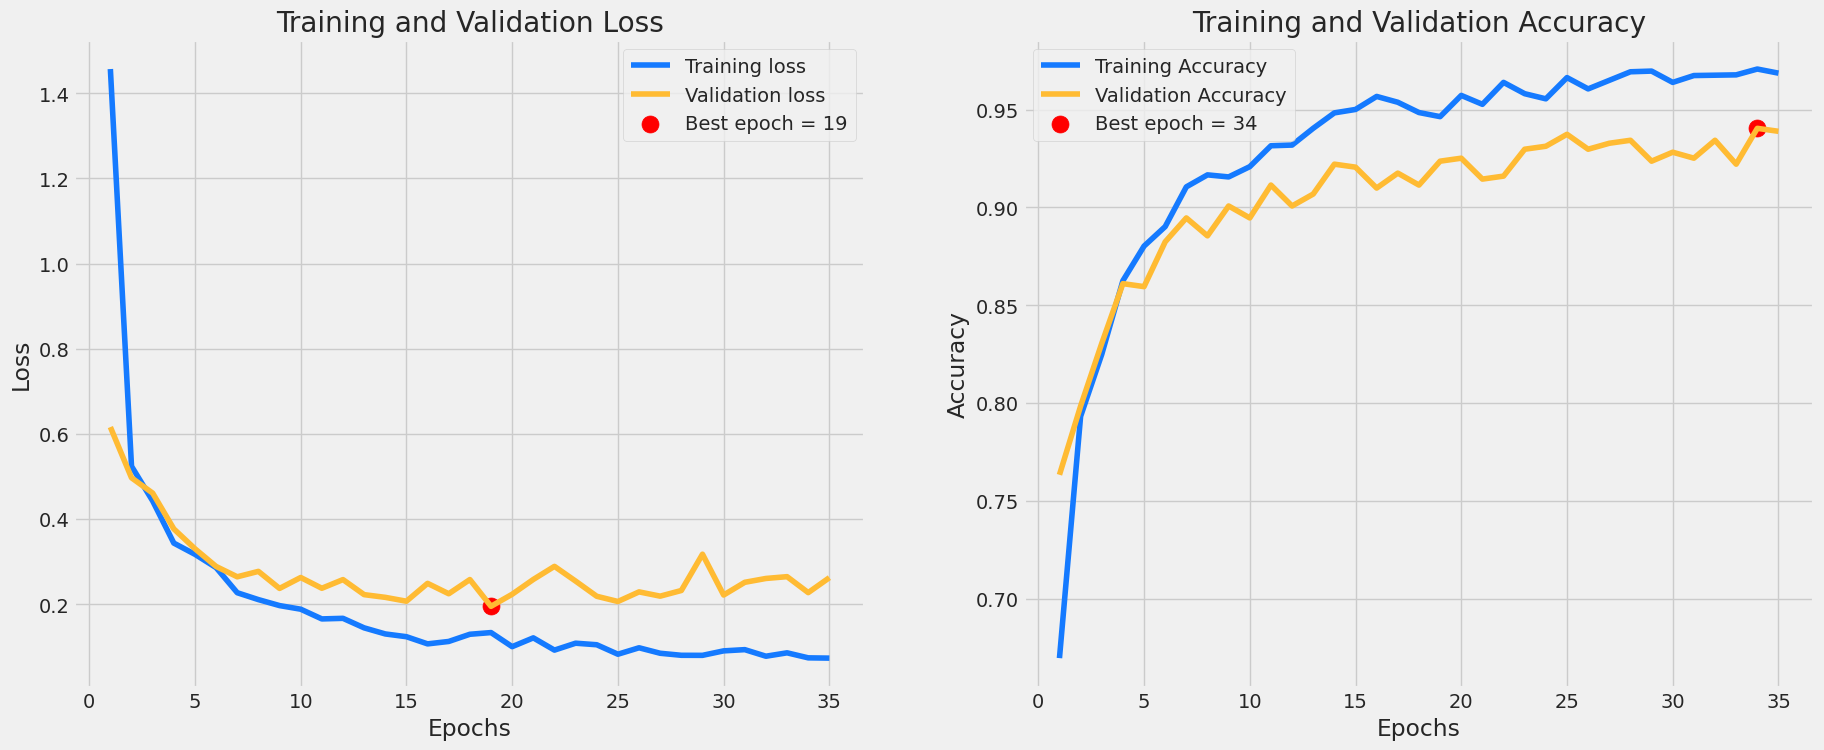

In [ ]:
#Graph results
tr_acc = xception_history.history['accuracy']
tr_loss = xception_history.history['loss']
val_acc = xception_history.history['val_accuracy']
val_loss = xception_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
#Results for training, validating, testings
train_score = xception_model.evaluate(train_gen, verbose = 1)
valid_score = xception_model.evaluate(valid_gen, verbose = 1)
test_score = xception_model.evaluate(test_gen, verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

21/21 [==============================] - 3s 145ms/step - loss: 0.2694 - accuracy: 0.9405
Train Loss:  0.01111740991473198
Train Accuracy:  0.9966736435890198
--------------------
Validation Loss:  0.26267150044441223
Validation Accuracy:  0.9389312863349915
--------------------
Test Loss:  0.2693604826927185
Test Accuracy:  0.9405487775802612


21/21 [==============================] - 4s 145ms/step


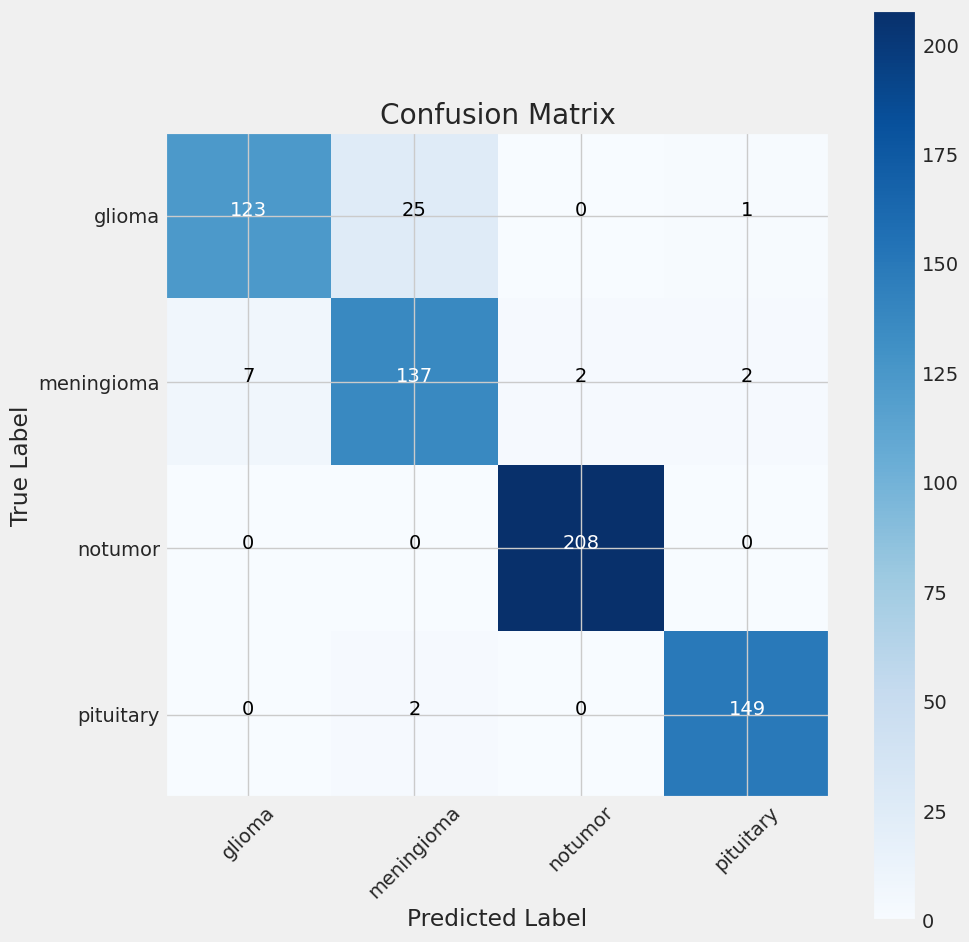

In [ ]:
preds = xception_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
xception_model.save("Xception.h5")

# ***------------MobileNetV2------------***

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model, pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top of the MobileNetV2 base model
mobile_net_model = Sequential([
    Input(shape=(img_size, img_size, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation='softmax')
])

# Compile the model
mobile_net_model.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
mobile_net_model.summary()


9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 81920)             0         
                                                                 
 dropout_6 (Dropout)         (None, 81920)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               10485888  
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 51

In [ ]:
# Start time
start_time = time.time()

# Train the model
mobile_net_history = mobile_net_model.fit(
    train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)

# End time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print training time
print(f"Training Time: {training_time} seconds")

# CPU utilization
cpu_utilization = psutil.cpu_percent()
print(f"CPU Utilization: {cpu_utilization}%")

# GPU utilization
gpus = GPUtil.getGPUs()
gpu_utilization = [gpu.load for gpu in gpus]
print(f"GPU Utilization: {gpu_utilization}")


Epoch 1/20
179/179 [==============================] - 26s 122ms/step - loss: 0.4620 - accuracy: 0.8447 - val_loss: 0.2940 - val_accuracy: 0.8809
Epoch 2/20
179/179 [==============================] - 18s 100ms/step - loss: 0.2216 - accuracy: 0.9209 - val_loss: 0.1956 - val_accuracy: 0.9176
Epoch 3/20
179/179 [==============================] - 20s 110ms/step - loss: 0.1553 - accuracy: 0.9429 - val_loss: 0.1798 - val_accuracy: 0.9252
Epoch 4/20
179/179 [==============================] - 19s 104ms/step - loss: 0.1089 - accuracy: 0.9606 - val_loss: 0.2134 - val_accuracy: 0.9267
Epoch 5/20
179/179 [==============================] - 23s 128ms/step - loss: 0.0782 - accuracy: 0.9688 - val_loss: 0.1656 - val_accuracy: 0.9237
Epoch 6/20
179/179 [==============================] - 19s 104ms/step - loss: 0.0703 - accuracy: 0.9727 - val_loss: 0.2029 - val_accuracy: 0.9267
Epoch 7/20
179/179 [==============================] - 19s 109ms/step - loss: 0.0534 - accuracy: 0.9807 - val_loss: 0.1802 - val_ac

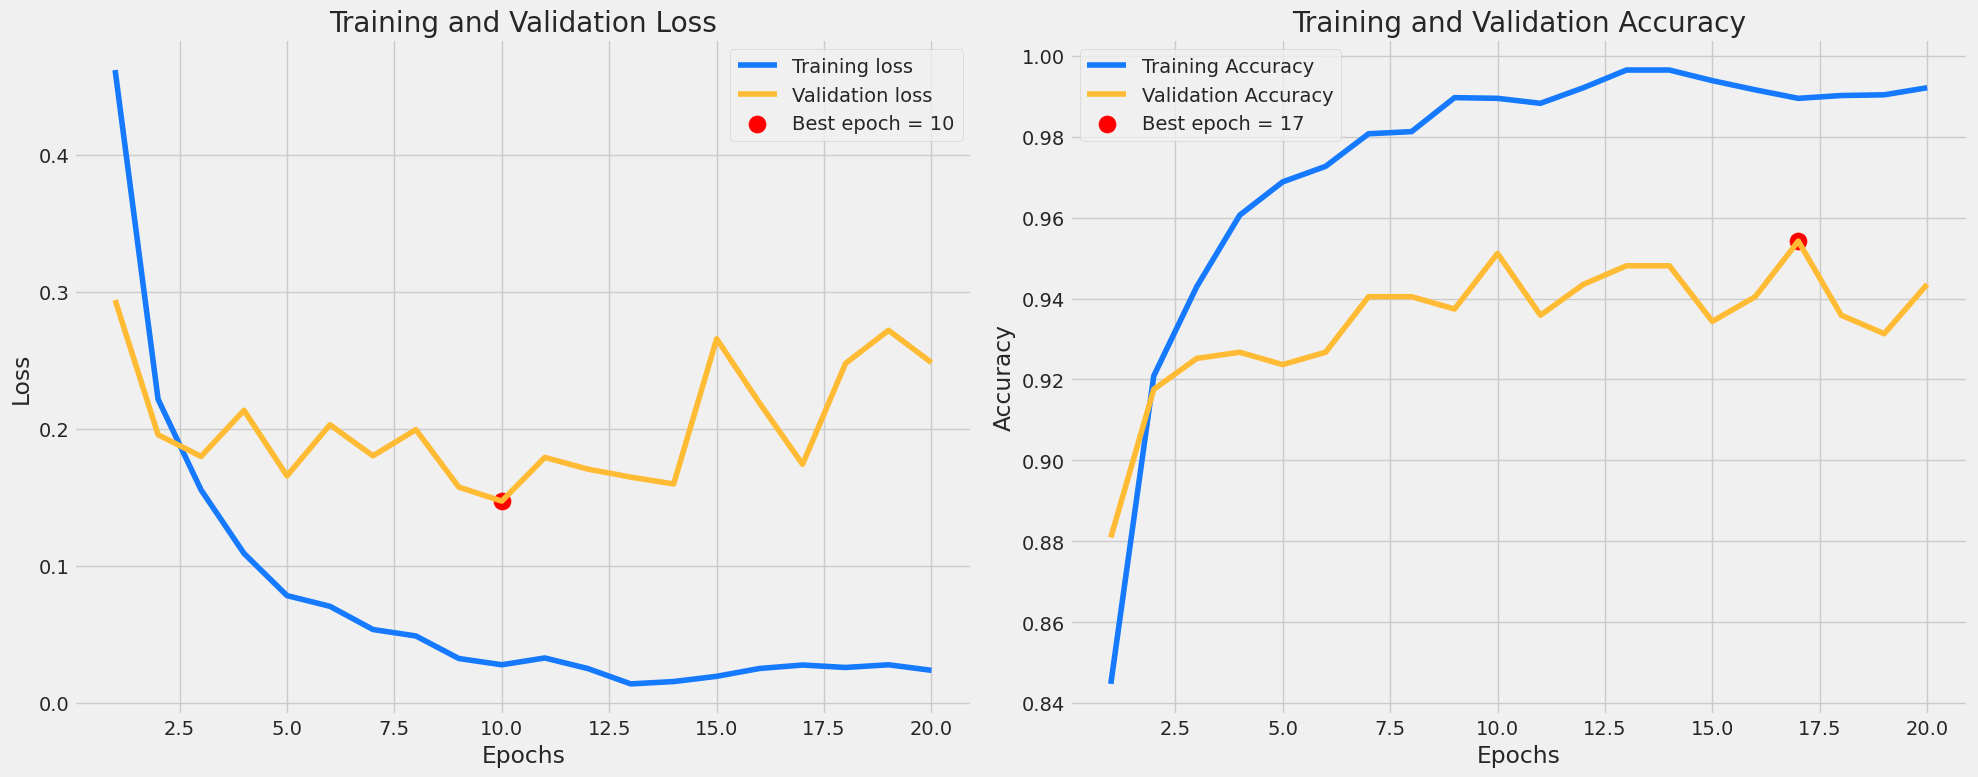

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tr_acc = mobile_net_history.history['accuracy']
tr_loss = mobile_net_history.history['loss']
val_acc = mobile_net_history.history['val_accuracy']
val_loss = mobile_net_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color='#157AFF', label='Training loss')
plt.plot(Epochs, val_loss, color='#FFBB33', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, color='red', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color='#157AFF', label='Training Accuracy')
plt.plot(Epochs, val_acc, color='#FFBB33', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, color='red', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Results for training, validating, testings
train_score = mobile_net_model.evaluate(train_gen, verbose=1)
valid_score = mobile_net_model.evaluate(valid_gen, verbose=1)
test_score = mobile_net_model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


21/21 [==============================] - 2s 82ms/step - loss: 0.2299 - accuracy: 0.9390
Train Loss:  0.004455691669136286
Train Accuracy:  0.9989495873451233
--------------------
Validation Loss:  0.2482859194278717
Validation Accuracy:  0.943511426448822
--------------------
Test Loss:  0.22991806268692017
Test Accuracy:  0.9390243887901306


21/21 [==============================] - 3s 75ms/step


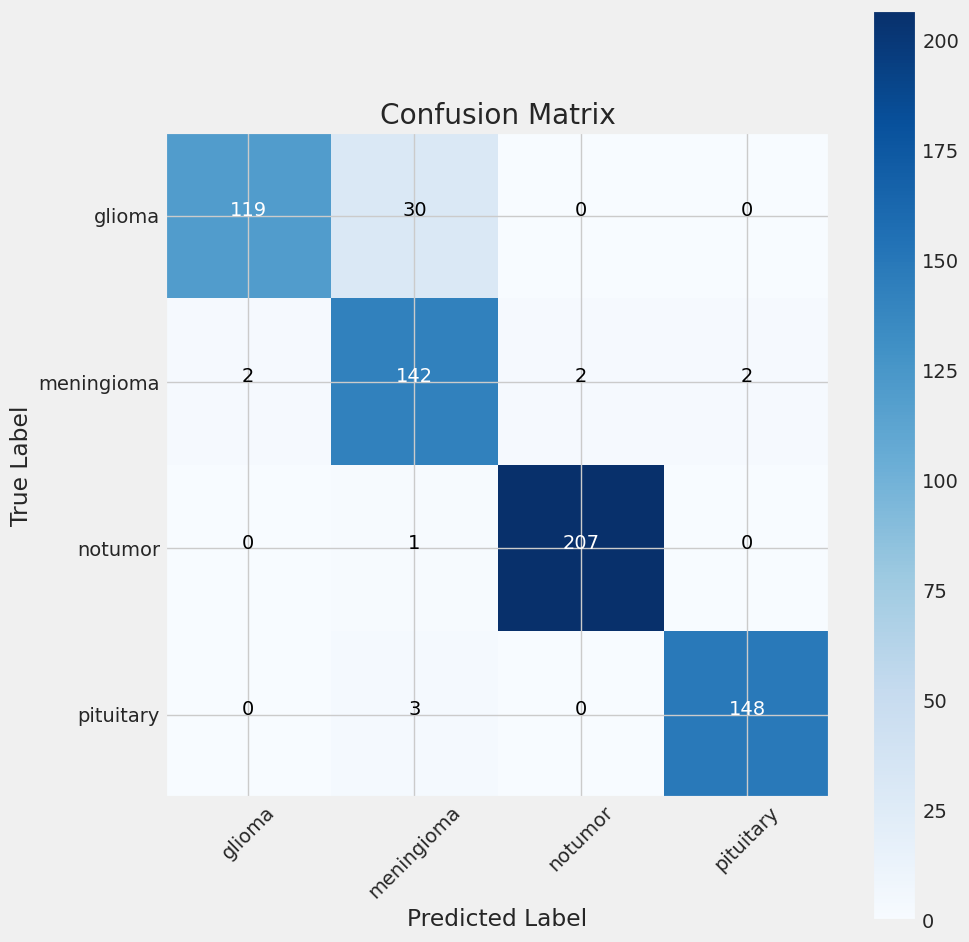

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predictions
preds = mobile_net_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
mobile_net_model.save("MobileNet.h5")

# ***------------EfficientNetB7---------***

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load the EfficientNetB7 model, pre-trained on ImageNet
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top of the EfficientNetB7 base model
efficient_net_model = Sequential([
    Input(shape=(img_size, img_size, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation='softmax')
])

# Compile the model
efficient_net_model.compile(optimizer=Adam(learning_rate=0.0001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Display model summary
efficient_net_model.summary()


258076736/258076736 [==============================] - 12s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 8, 8, 2560)        64097687  
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 163840)            0         
                                                                 
 dropout_2 (Dropout)         (None, 163840)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               20971648  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)              

In [ ]:
import time
import psutil
import GPUtil

# Start time
start_time = time.time()

# Train the model
efficient_net_history = efficient_net_model.fit(
    train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)

# End time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print training time
print(f"Training Time: {training_time} seconds")

# CPU utilization
cpu_utilization = psutil.cpu_percent()
print(f"CPU Utilization: {cpu_utilization}%")

# GPU utilization
gpus = GPUtil.getGPUs()
gpu_utilization = [gpu.load for gpu in gpus]
print(f"GPU Utilization: {gpu_utilization}")


Epoch 1/20
179/179 [==============================] - 128s 566ms/step - loss: 0.5040 - accuracy: 0.8223 - val_loss: 0.3340 - val_accuracy: 0.8595
Epoch 2/20
179/179 [==============================] - 85s 474ms/step - loss: 0.2276 - accuracy: 0.9137 - val_loss: 0.2282 - val_accuracy: 0.9130
Epoch 3/20
179/179 [==============================] - 83s 466ms/step - loss: 0.1676 - accuracy: 0.9361 - val_loss: 0.2049 - val_accuracy: 0.9160
Epoch 4/20
179/179 [==============================] - 83s 462ms/step - loss: 0.1444 - accuracy: 0.9466 - val_loss: 0.1964 - val_accuracy: 0.9252
Epoch 5/20
179/179 [==============================] - 82s 459ms/step - loss: 0.1141 - accuracy: 0.9561 - val_loss: 0.1454 - val_accuracy: 0.9450
Epoch 6/20
179/179 [==============================] - 84s 470ms/step - loss: 0.0884 - accuracy: 0.9674 - val_loss: 0.1367 - val_accuracy: 0.9511
Epoch 7/20
179/179 [==============================] - 82s 459ms/step - loss: 0.0854 - accuracy: 0.9659 - val_loss: 0.1186 - val_a

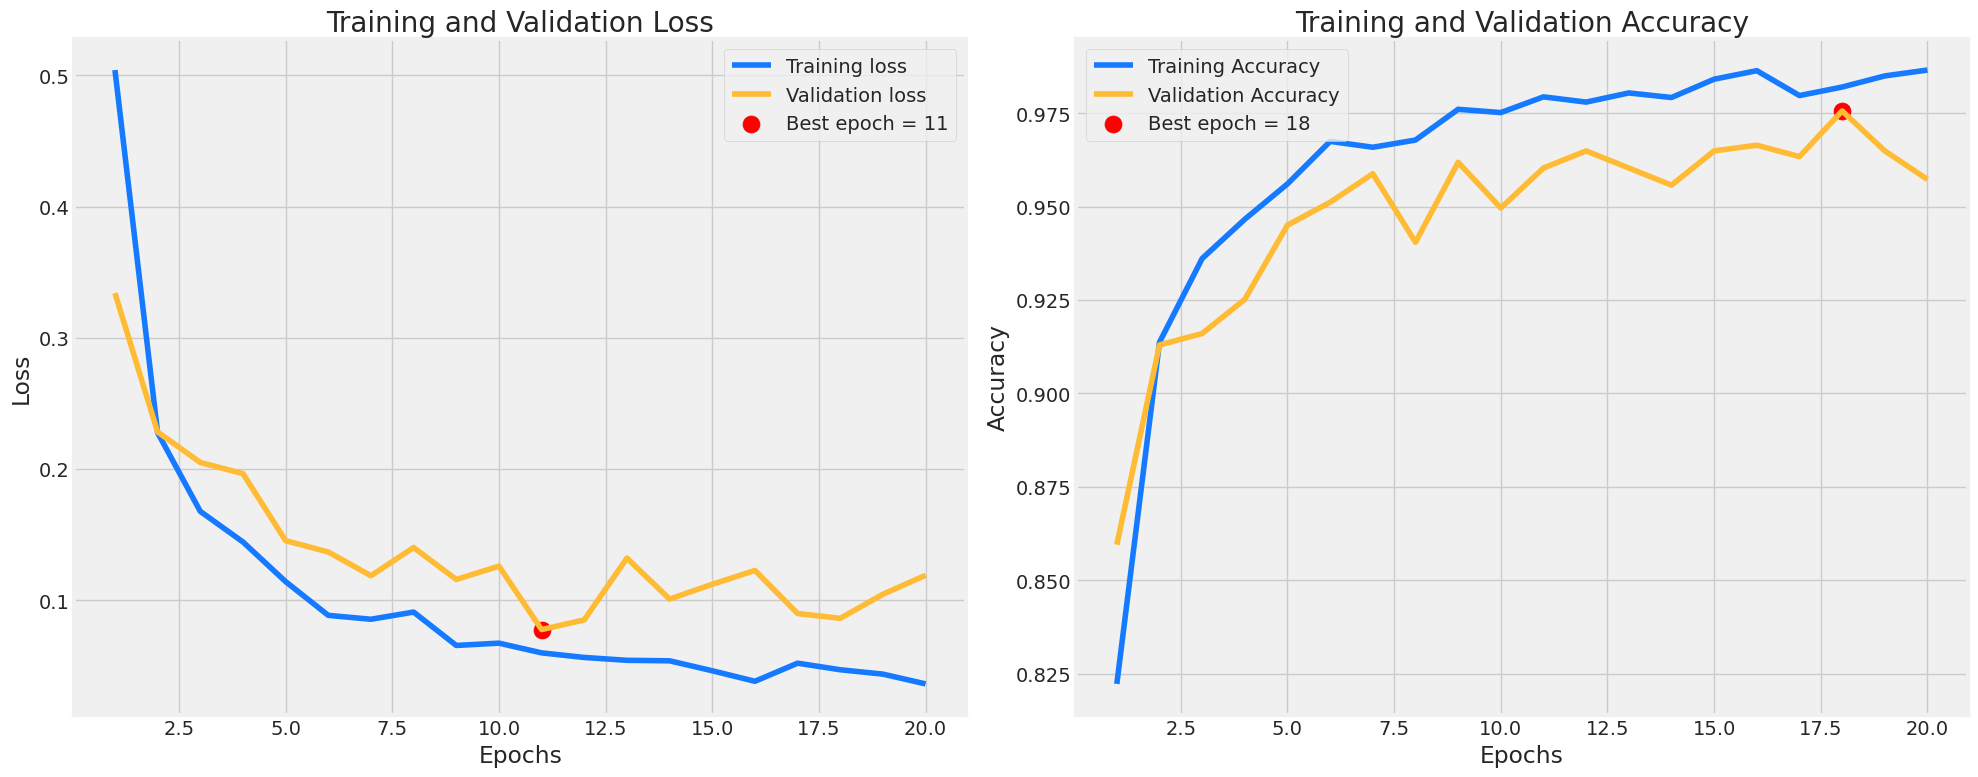

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting training and validation statistics from the EfficientNet training history
tr_acc = efficient_net_history.history['accuracy']
tr_loss = efficient_net_history.history['loss']
val_acc = efficient_net_history.history['val_accuracy']
val_loss = efficient_net_history.history['val_loss']

# Identify indices of the best and worst performance
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Generate a list of epoch numbers
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for the best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Setting up the plot
plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Results for training, validating, testings
train_score = efficient_net_model.evaluate(train_gen, verbose=1)
valid_score = efficient_net_model.evaluate(valid_gen, verbose=1)
test_score = efficient_net_model.evaluate(test_gen, verbose=1)

# Output results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


21/21 [==============================] - 8s 391ms/step - loss: 0.0889 - accuracy: 0.9710
Train Loss:  0.011966176331043243
Train Accuracy:  0.9970238208770752
--------------------
Validation Loss:  0.11894258856773376
Validation Accuracy:  0.9572519063949585
--------------------
Test Loss:  0.08887773752212524
Test Accuracy:  0.9710366129875183


21/21 [==============================] - 17s 392ms/step


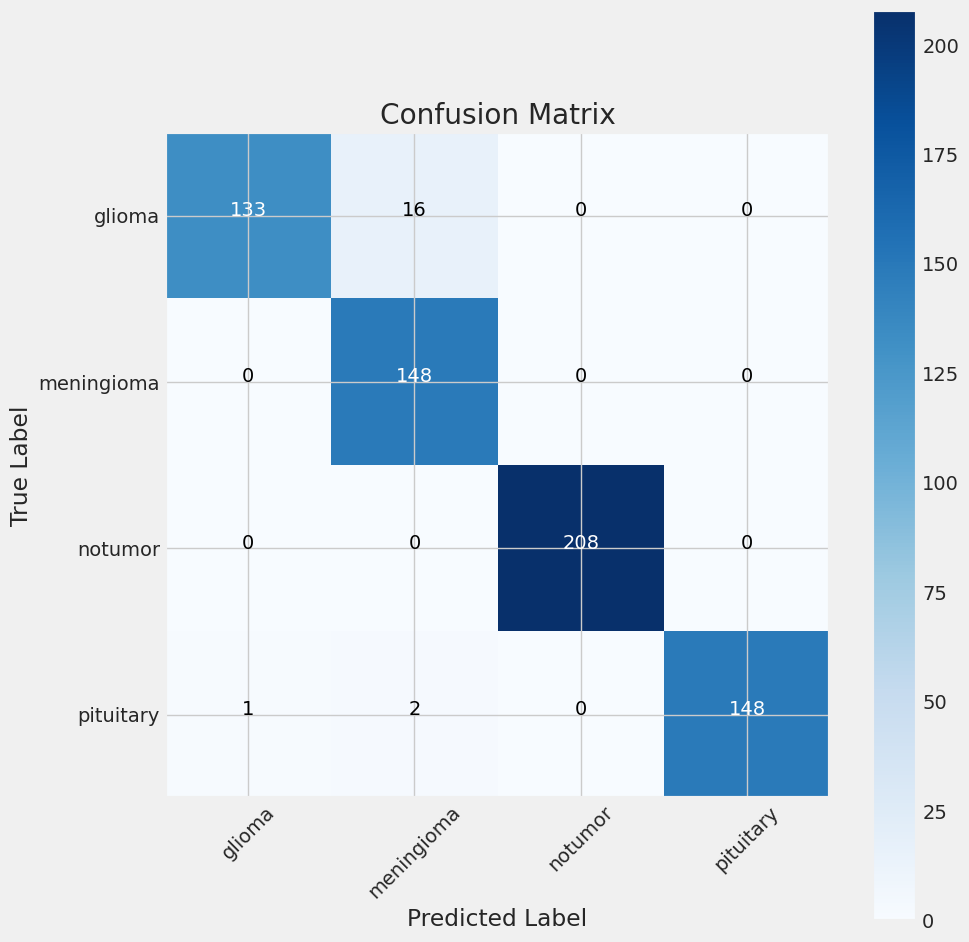

In [ ]:
# Make predictions with EfficientNet model
preds = efficient_net_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Generate the confusion matrix
g_dict = test_gen.class_indices  # Dictionary of classes
classes = list(g_dict.keys())  # List of class labels

# Compute the confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Setting tick marks for class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate the confusion matrix with text in center of squares
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
efficient_net_model.save("EfficientNet.h5")

# ***Ensemble Model 1 (VGG16, InceptionV3, Xception)***

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, InceptionV3, Xception
from tensorflow.keras.models import Sequential

# Define the input layer
input_layer = Input(shape=(img_size, img_size, 3))

# Load the base models with shared input layer
def build_base_model(model, input_layer):
    base_model = model(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False  # Freeze the base model
    return Sequential([
        base_model,
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2)
    ])

# Construct each base model with the custom architecture
vgg16_model = build_base_model(VGG16, input_layer)
inception_model = build_base_model(InceptionV3, input_layer)
xception_model = build_base_model(Xception, input_layer)

# Get output from each model
vgg16_output = vgg16_model(input_layer)
inception_output = inception_model(input_layer)
xception_output = xception_model(input_layer)

# Combine outputs
merged = concatenate([vgg16_output, inception_output, xception_output])

# Final classification layer
final_output = Dense(class_count, activation='softmax')(merged)

# Create the ensemble model
ensemble_model1 = Model(inputs=input_layer, outputs=final_output)

# Compile the ensemble model
ensemble_model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
ensemble_model1.summary()

# Train the model
ensemble_history1 = ensemble_model1.fit(
    train_gen,
    epochs=15,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 128)                  1792608   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 sequential_5 (Sequential)   (None, 128)                  3124009   ['input_4[0][0]']             
                                                          6                                       
                                                                                            

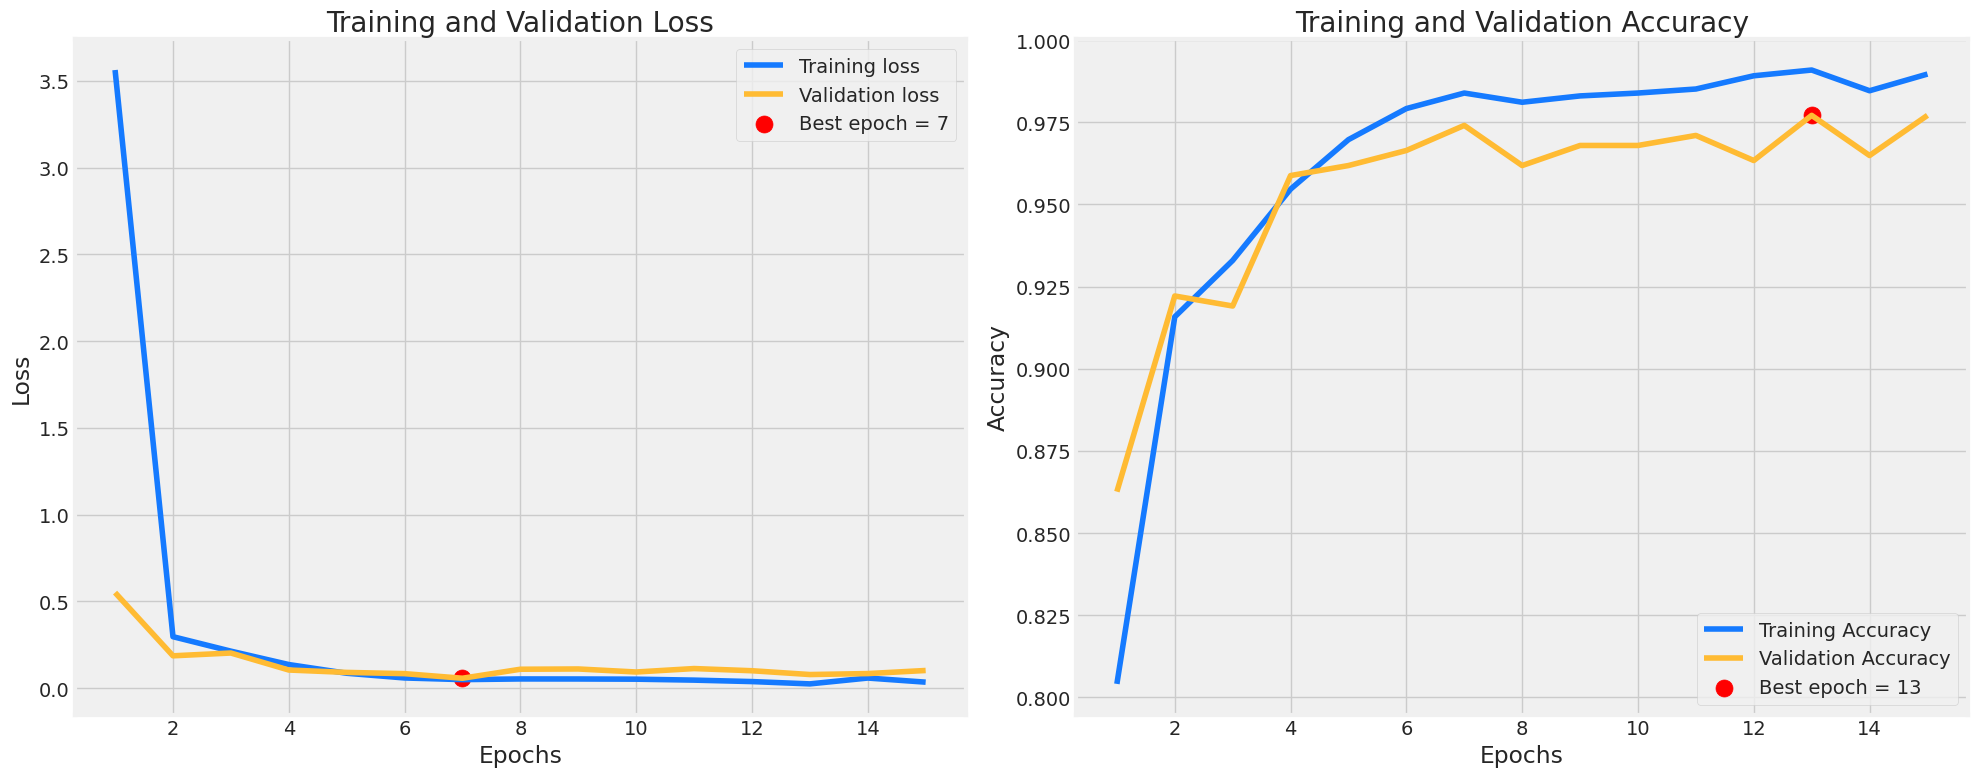

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting training and validation statistics from the EfficientNet training history
tr_acc = ensemble_history1.history['accuracy']
tr_loss = ensemble_history1.history['loss']
val_acc = ensemble_history1.history['val_accuracy']
val_loss = ensemble_history1.history['val_loss']

# Identify indices of the best and worst performance
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Generate a list of epoch numbers
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for the best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Setting up the plot
plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Results for training, validating, testings
train_score = ensemble_model1.evaluate(train_gen, verbose=1)
valid_score = ensemble_model1.evaluate(valid_gen, verbose=1)
test_score = ensemble_model1.evaluate(test_gen, verbose=1)

# Output results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


21/21 [==============================] - 7s 337ms/step - loss: 0.1111 - accuracy: 0.9771
Train Loss:  0.003925198223441839
Train Accuracy:  0.9992997050285339
--------------------
Validation Loss:  0.10200481861829758
Validation Accuracy:  0.9770992398262024
--------------------
Test Loss:  0.11109805852174759
Test Accuracy:  0.9771341681480408


# ***Ensemble Model 2 (VGG16, MobileNetV2, EfficientNetB7)***

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, InceptionV3, Xception
from tensorflow.keras.models import Sequential

# Define the input layer
input_layer = Input(shape=(img_size, img_size, 3))

# Load the base models with shared input layer
def build_base_model(model, input_layer):
    base_model = model(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False  # Freeze the base model
    return Sequential([
        base_model,
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2)
    ])

# Construct each base model with the custom architecture
vgg16_model = build_base_model(VGG16, input_layer)
mobileNet_model = build_base_model(MobileNetV2, input_layer)
efficientNet_model = build_base_model(EfficientNetB7, input_layer)

# Get output from each model
vgg16_output = vgg16_model(input_layer)
mobileNet_output = mobileNet_model(input_layer)
efficientNet_output = efficientNet_model(input_layer)

# Combine outputs
merged = concatenate([vgg16_output, mobileNet_output, efficientNet_output])

# Final classification layer
final_output = Dense(class_count, activation='softmax')(merged)

# Create the ensemble model
ensemble_model2 = Model(inputs=input_layer, outputs=final_output)

# Compile the ensemble model
ensemble_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
ensemble_model2.summary()

# Train the model
ensemble_history2 = ensemble_model2.fit(
    train_gen,
    epochs=15,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)


9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128)                  1792608   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 sequential_3 (Sequential)   (None, 128)                  1274387   ['input_5[0][0]']             
                                                          2                                       
                               

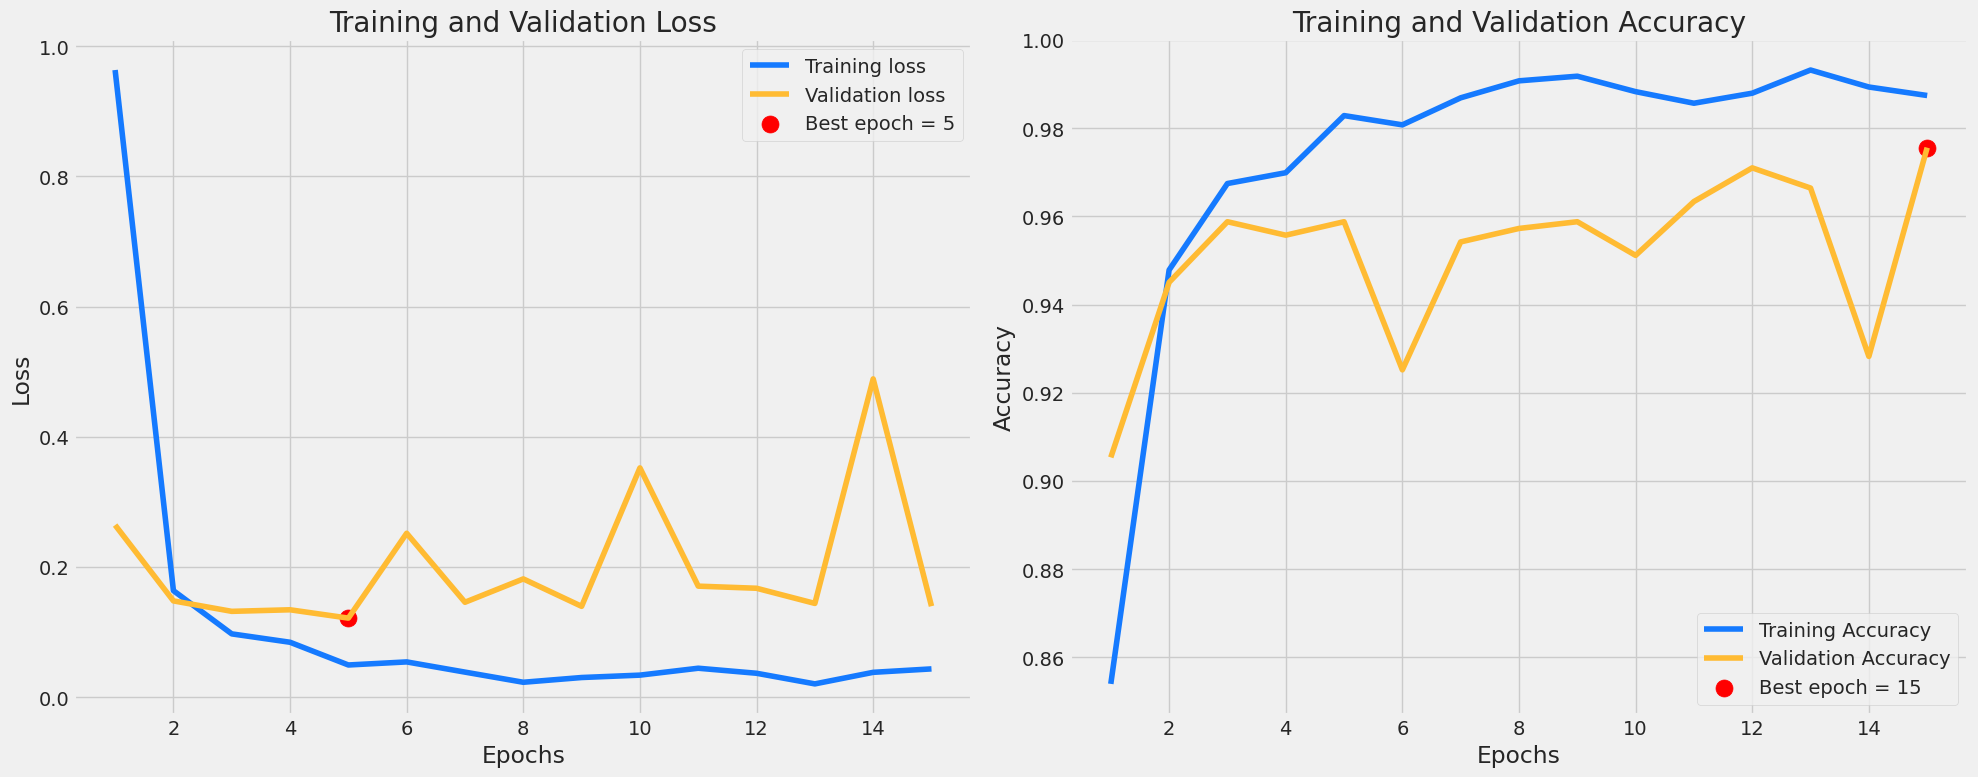

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting training and validation statistics from the EfficientNet training history
tr_acc = ensemble_history2.history['accuracy']
tr_loss = ensemble_history2.history['loss']
val_acc = ensemble_history2.history['val_accuracy']
val_loss = ensemble_history2.history['val_loss']

# Identify indices of the best and worst performance
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Generate a list of epoch numbers
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for the best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Setting up the plot
plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Results for training, validating, testings
train_score = ensemble_model2.evaluate(train_gen, verbose=1)
valid_score = ensemble_model2.evaluate(valid_gen, verbose=1)
test_score = ensemble_model2.evaluate(test_gen, verbose=1)

# Output results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


21/21 [==============================] - 12s 547ms/step - loss: 0.0878 - accuracy: 0.9787
Train Loss:  0.0026874388568103313
Train Accuracy:  0.9991246461868286
--------------------
Validation Loss:  0.1395702362060547
Validation Accuracy:  0.9755725264549255
--------------------
Test Loss:  0.08784952759742737
Test Accuracy:  0.9786585569381714


# ***Ensemble Model 3 (MobileNetV2, EfficientNetB7, Xception)***

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, InceptionV3, Xception
from tensorflow.keras.models import Sequential

# Define the input layer
input_layer = Input(shape=(img_size, img_size, 3))

# Load the base models with shared input layer
def build_base_model(model, input_layer):
    base_model = model(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False  # Freeze the base model
    return Sequential([
        base_model,
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2)
    ])

# Construct each base model with the custom architecture
mobileNet_model = build_base_model(MobileNetV2, input_layer)
efficientNet_model = build_base_model(EfficientNetB7, input_layer)
xception_model = build_base_model(Xception, input_layer)

# Get output from each model
mobileNet_output = mobileNet_model(input_layer)
efficient_output = efficientNet_model(input_layer)
xception_output = xception_model(input_layer)

# Combine outputs
merged = concatenate([mobileNet_output, efficient_output, xception_output])

# Final classification layer
final_output = Dense(class_count, activation='softmax')(merged)

# Create the ensemble model
ensemble_model3 = Model(inputs=input_layer, outputs=final_output)

# Compile the ensemble model
ensemble_model3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
ensemble_model3.summary()

# Train the model
ensemble_history3 = ensemble_model3.fit(
    train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)


258076736/258076736 [==============================] - 5s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 sequential_7 (Sequential)   (None, 128)                  1274387   ['input_5[0][0]']             
                                                          2                                       
                                                                                                  
 sequential_8 (Sequential)   (None, 128)                  8506933   ['input_5[0][0]']             
                                                          5                                       
                         

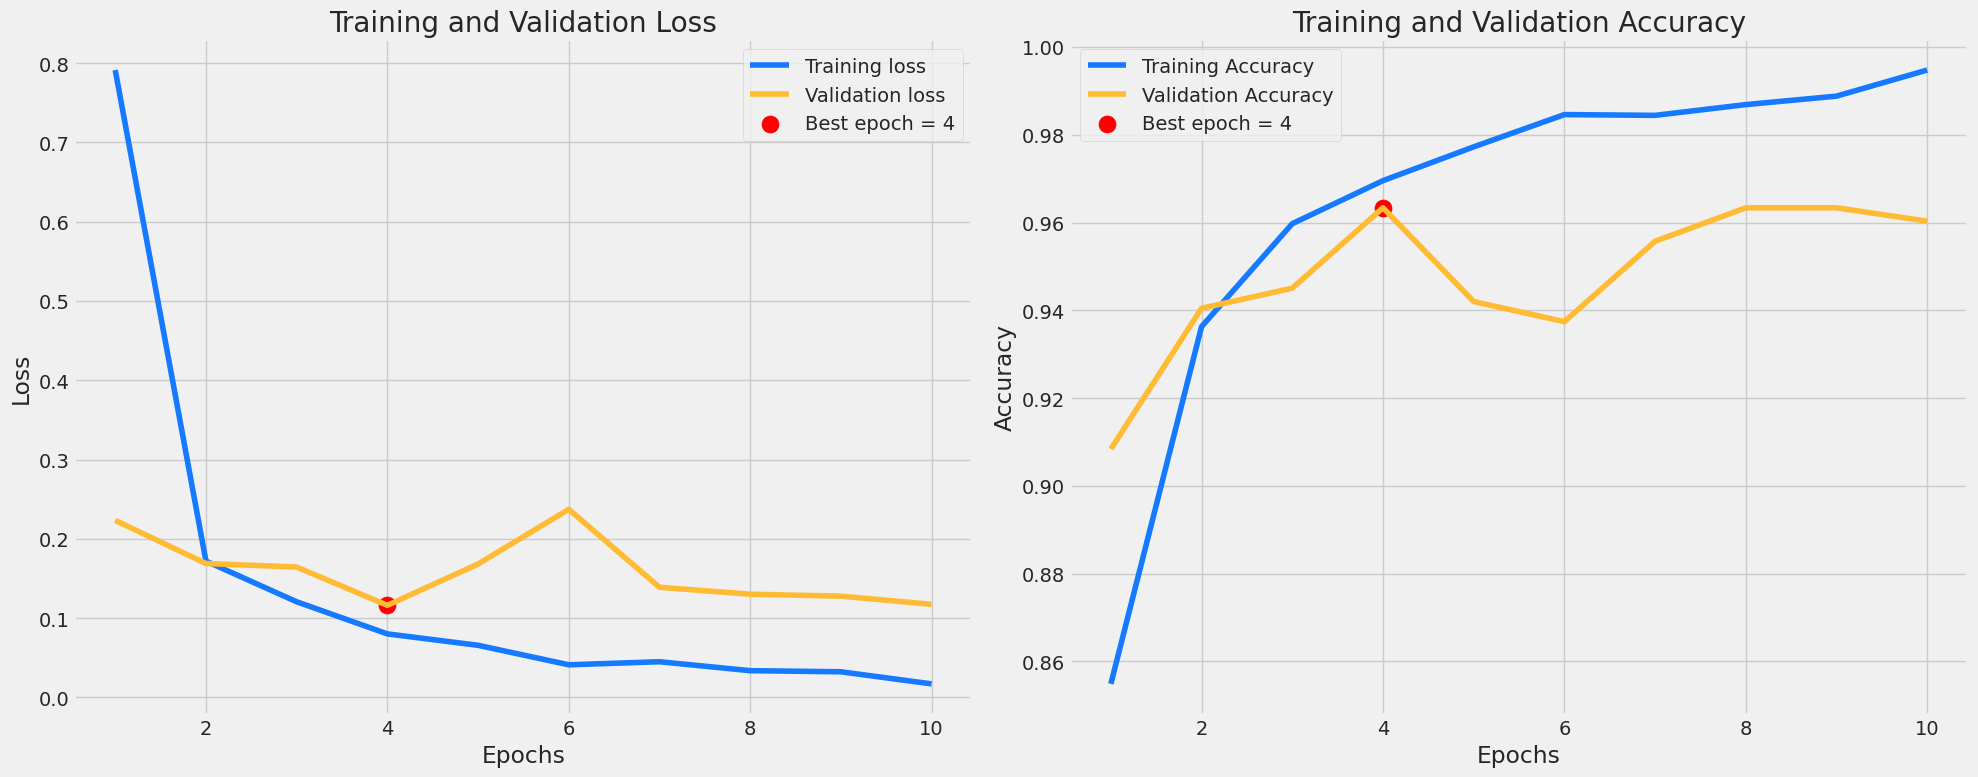

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting training and validation statistics from the EfficientNet training history
tr_acc = ensemble_history3.history['accuracy']
tr_loss = ensemble_history3.history['loss']
val_acc = ensemble_history3.history['val_accuracy']
val_loss = ensemble_history3.history['val_loss']

# Identify indices of the best and worst performance
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Generate a list of epoch numbers
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for the best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Setting up the plot
plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Results for training, validating, testings
train_score = ensemble_model3.evaluate(train_gen, verbose=1)
valid_score = ensemble_model3.evaluate(valid_gen, verbose=1)
test_score = ensemble_model3.evaluate(test_gen, verbose=1)

# Output results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


21/21 [==============================] - 12s 545ms/step - loss: 0.0695 - accuracy: 0.9787
Train Loss:  0.0022442974150180817
Train Accuracy:  1.0
--------------------
Validation Loss:  0.1174488216638565
Validation Accuracy:  0.9603053331375122
--------------------
Test Loss:  0.06945982575416565
Test Accuracy:  0.9786585569381714
